In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import imageio
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

import i3d
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15410845541526399368
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7919681536
locality {
  bus_id: 1
}
incarnation: 5932959951337074466
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [2]:
"""
Build Joint Stream Graph (from i3d.py)
"""
_IMAGE_SIZE = 224
_NUM_CLASSES = 400

_SAMPLE_VIDEO_FRAMES = 25
_SAMPLE_PATHS = {
    'rgb': 'data/v_CricketShot_g04_c01_rgb.npy',
    'flow': 'data/v_CricketShot_g04_c01_flow.npy',
}

_CHECKPOINT_PATHS = {
    'rgb': 'data/checkpoints/rgb_scratch/model.ckpt',
    'flow': 'data/checkpoints/flow_scratch/model.ckpt',
    'rgb_imagenet': 'data/checkpoints/rgb_imagenet/model.ckpt',
    'flow_imagenet': 'data/checkpoints/flow_imagenet/model.ckpt',
}

_LABEL_MAP_PATH = 'data/label_map.txt'



imagenet_pretrained = True # use pretrained model as it had better performance
eval_type = "joint" # build the graph for both streams 
tf.reset_default_graph() # reset graph each time cell is run, prevents duplicate variables

if eval_type not in ['rgb', 'flow', 'joint']:
    raise ValueError('Bad `eval_type`, must be one of rgb, flow, joint')

kinetics_classes = [x.strip() for x in open(_LABEL_MAP_PATH)]

if eval_type in ['rgb', 'joint']:
    # RGB input has 3 channels.
    rgb_input = tf.placeholder(
        tf.float32,
        shape=(1, None, _IMAGE_SIZE, _IMAGE_SIZE, 3))
    with tf.variable_scope('RGB'):
        rgb_model = i3d.InceptionI3d(
            _NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        rgb_logits, _ = rgb_model(
            rgb_input, is_training=False, dropout_keep_prob=1.0)
    rgb_variable_map = {}
    for variable in tf.global_variables():
        if variable.name.split('/')[0] == 'RGB':
            rgb_variable_map[variable.name.replace(':0', '')] = variable
    rgb_saver = tf.train.Saver(var_list=rgb_variable_map, reshape=True)

if eval_type in ['flow', 'joint']:
    # Flow input has only 2 channels.
    flow_input = tf.placeholder(
        tf.float32,
        shape=(1, None, _IMAGE_SIZE, _IMAGE_SIZE, 2))
    with tf.variable_scope('Flow'):
        flow_model = i3d.InceptionI3d(
            _NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        flow_logits, _ = flow_model(
            flow_input, is_training=False, dropout_keep_prob=1.0)
    flow_variable_map = {}
    for variable in tf.global_variables():
        if variable.name.split('/')[0] == 'Flow':
            flow_variable_map[variable.name.replace(':0', '')] = variable
    flow_saver = tf.train.Saver(var_list=flow_variable_map, reshape=True)

if eval_type == 'rgb':
    model_logits = rgb_logits
elif eval_type == 'flow':
    model_logits = flow_logits
else:
    model_logits = rgb_logits + flow_logits
model_predictions = tf.nn.softmax(model_logits)

In [3]:
"""
Run sample (playing cricket) prediction with joint
"""
eval_type = "joint"
with tf.Session() as sess:
        feed_dict = {}
        if eval_type in ['rgb', 'joint']:
            if imagenet_pretrained:
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
            else:
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb'])
            tf.logging.info('RGB checkpoint restored')
            rgb_sample = np.load(_SAMPLE_PATHS['rgb'])
            print("RGB size:", rgb_sample.shape)
            tf.logging.info('RGB data loaded, shape=%s', str(rgb_sample.shape))
            feed_dict[rgb_input] = rgb_sample

        if eval_type in ['flow', 'joint']:
            if imagenet_pretrained:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow_imagenet'])
            else:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow'])
            tf.logging.info('Flow checkpoint restored')
            flow_sample = np.load(_SAMPLE_PATHS['flow'])
            print("flow size:", flow_sample.shape)
            tf.logging.info('Flow data loaded, shape=%s',
                            str(flow_sample.shape))
            feed_dict[flow_input] = flow_sample
        # print("feed_dict", feed_dict)
        out_logits, out_predictions = sess.run(
            [model_logits, model_predictions],
            feed_dict=feed_dict)

        out_logits = out_logits[0]
        out_predictions = out_predictions[0]
        sorted_indices = np.argsort(out_predictions)[::-1]

        print('Norm of logits: %f' % np.linalg.norm(out_logits))
        print('\nTop classes and probabilities')
        for index in sorted_indices[:20]:
            print(out_predictions[index], out_logits[
                  index], kinetics_classes[index])

INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
INFO:tensorflow:RGB checkpoint restored
RGB size: (1, 79, 224, 224, 3)
INFO:tensorflow:RGB data loaded, shape=(1, 79, 224, 224, 3)
INFO:tensorflow:Restoring parameters from data/checkpoints/flow_imagenet/model.ckpt
INFO:tensorflow:Flow checkpoint restored
flow size: (1, 79, 224, 224, 2)
INFO:tensorflow:Flow data loaded, shape=(1, 79, 224, 224, 2)
Norm of logits: 138.468658

Top classes and probabilities
1.0 41.813683 playing cricket
1.497162e-09 21.493988 hurling (sport)
3.8430797e-10 20.134106 catching or throwing baseball
1.54923e-10 19.22559 catching or throwing softball
1.1360122e-10 18.915356 hitting baseball
8.801088e-11 18.660122 playing tennis
2.441537e-11 17.377874 playing kickball
1.153184e-11 16.627773 playing squash or racquetball
6.1318776e-12 15.996162 shooting goal (soccer)
4.391727e-12 15.662385 hammer throw
2.2134183e-12 14.9772 golf putting
1.6307032e-12 14.671674 throwing discus
1.5456

In [4]:
from scipy.ndimage.filters import gaussian_filter1d
def blur_image(X, sigma=1.5):
    # start = time.time()
    X = gaussian_filter1d(X, sigma, axis=1)
    X = gaussian_filter1d(X, sigma, axis=2)
    X = gaussian_filter1d(X, sigma, axis=3)
    # print("Blur time", time.time()-start)
    return X


def create_flow_image(X):
        return np.append(X + 0.5, 0.5 * np.ones((224, 224, 1)), axis=2)


def save_gif(X, class_name, stream_type):
    # save all frames
    num_frames = X.shape[1]
    directory = "experiments_{}/{}/".format(stream_type, class_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    image_name = "{}_{}".format(class_name, stream_type)
    file_name = directory + image_name + "{}.png"
    print("file_name", file_name)
    filenames = []
    for i in range(0, num_frames):
        if stream_type == "rgb":
            plt.imshow(X[0][i])
        elif stream_type == "flow":
            plt.imshow(create_flow_image(X[0][i]))
        
        filename = file_name.format(i)
        filenames.append(filename)
        plt.savefig(filename.format(i))
        # plt.show()
    
    #create gif
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
        imageio.mimsave(directory + "/{}".format(image_name) + ".gif", images)

In [5]:
def create_class_visualization(sess, rgb_input, flow_input, target_y, logits, class_name, **kwargs):
    """
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    print("params", kwargs)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 4)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)
    num_frames = kwargs.pop('num_frames', 25)
    stream_type = kwargs.pop('stream_type', 'rgb')
    sigma = kwargs.pop('sigma', 1)
    
    # X = np.random.rand(num_frames, 224, 224, 3)
    if stream_type == 'rgb':
        stream_input = rgb_input
        X = np.random.rand(1, 224, 224, 3) * np.ones((num_frames, 224, 224, 3))
        X = X[None]
    elif stream_type == 'flow':
        stream_input = flow_input
        # may need to change noise instiantiation
        X = np.random.rand(1, 224, 224, 2) * np.ones((num_frames, 224, 224, 2))
        # preprocess as described in paper
        X = X - .5
        X = X[None]
        X = flow_sample
    
    loss = logits[0, target_y] # scalar loss

    grad = tf.gradients(loss, stream_input) # compute gradient
    grad = tf.squeeze(grad) - l2_reg*2*stream_input # regualarlize gradient

    start_time = time.time()
    for t in range(num_iterations):
        
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
        Xi = X.copy()
        X = np.roll(np.roll(X, ox, 1), oy, 2)

        # we want logits for loss, model.classifier are just logits
        loss = logits[0, target_y] # scalar loss

        # model.image is just the data matrix input (a gif in our case)
        gradient_step = sess.run(grad, feed_dict={stream_input:X})
        X += learning_rate * gradient_step

        # Undo the jitter
        X = np.roll(np.roll(X, -ox, 1), -oy, 2)

        # As a regularizer, clip and periodically blur
        if stream_type == 'flow':
            X = np.clip(X, -0.5, 0.5)
        elif stream_type == 'rgb':
            X = np.clip(X, 0, 1)
        
        if t % blur_every == 0:
            X = blur_image(X, sigma=sigma)
        
        print("iteration:", t, time.time()-start_time)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            
            if stream_type == "rgb":
                plt.imshow(X[0][0])
            elif stream_type == "flow":
                plt.imshow(create_flow_image(X[0][0]))
          
            if t == num_iterations-1:
                save_gif(X, class_name, stream_type)
                    
            plt.title('{}_{}\nIteration {} / {}'.format(class_name, stream_type, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()
        
    return X

Tensor("add:0", shape=(1, 400), dtype=float32)
Tensor("Placeholder:0", shape=(1, ?, 224, 224, 3), dtype=float32)
arm wrestling
INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
params {'max_jitter': 32, 'blur_every': 3, 'num_iterations': 1000, 'learning_rate': 1.5, 'num_frames': 25, 'stream_type': 'rgb'}
iteration: 0 3.41301488876


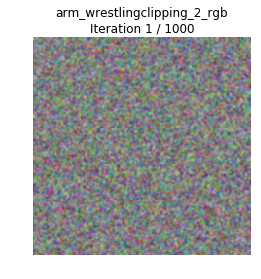

iteration: 1 3.74121880531
iteration: 2 3.9498360157
iteration: 3 4.32260394096
iteration: 4 4.55587482452
iteration: 5 4.8201379776
iteration: 6 5.19712591171
iteration: 7 5.40817594528
iteration: 8 5.64367294312
iteration: 9 5.96430802345
iteration: 10 6.17903494835
iteration: 11 6.39312887192
iteration: 12 6.74074697495
iteration: 13 6.96677899361
iteration: 14 7.22115683556
iteration: 15 7.66499996185
iteration: 16 7.90425801277
iteration: 17 8.16430187225
iteration: 18 8.51652002335
iteration: 19 8.73828697205
iteration: 20 8.9876229763
iteration: 21 9.41250181198
iteration: 22 9.64011979103
iteration: 23 9.89186692238
iteration: 24 10.2958710194


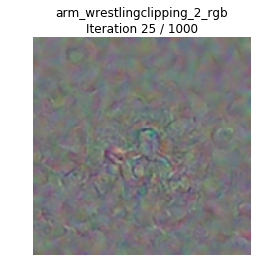

iteration: 25 10.6976130009
iteration: 26 10.9740598202
iteration: 27 11.4073488712
iteration: 28 11.6326658726
iteration: 29 11.8502428532
iteration: 30 12.182612896
iteration: 31 12.4064488411
iteration: 32 12.6885418892
iteration: 33 13.1261138916
iteration: 34 13.3596138954
iteration: 35 13.6266298294
iteration: 36 14.0336239338
iteration: 37 14.2592329979
iteration: 38 14.49928689
iteration: 39 14.9157350063
iteration: 40 15.1428029537
iteration: 41 15.3929009438
iteration: 42 15.8042788506
iteration: 43 16.0407419205
iteration: 44 16.3275868893
iteration: 45 16.7630398273
iteration: 46 17.0029687881
iteration: 47 17.2508478165
iteration: 48 17.6580879688
iteration: 49 17.8911209106


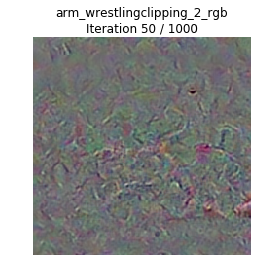

iteration: 50 18.2857289314
iteration: 51 18.7035338879
iteration: 52 18.9334409237
iteration: 53 19.1784758568
iteration: 54 19.5828008652
iteration: 55 19.8105478287
iteration: 56 20.0419588089
iteration: 57 20.4718298912
iteration: 58 20.7133569717
iteration: 59 20.9983158112
iteration: 60 21.438136816
iteration: 61 21.6788020134
iteration: 62 21.9686868191
iteration: 63 22.4079217911
iteration: 64 22.6448228359
iteration: 65 22.9008498192
iteration: 66 23.3366529942
iteration: 67 23.5723969936
iteration: 68 23.8562948704
iteration: 69 24.2891988754
iteration: 70 24.5186359882
iteration: 71 24.7652158737
iteration: 72 25.1839728355
iteration: 73 25.4131839275
iteration: 74 25.6592350006


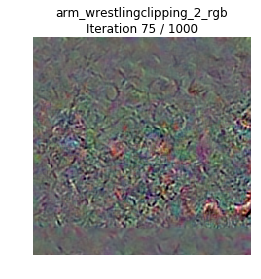

iteration: 75 26.115986824
iteration: 76 26.3353497982
iteration: 77 26.5553839207
iteration: 78 26.885529995
iteration: 79 27.1039099693
iteration: 80 27.3501429558
iteration: 81 27.7898058891
iteration: 82 28.0186138153
iteration: 83 28.2431199551
iteration: 84 28.5797078609
iteration: 85 28.8066439629
iteration: 86 29.0870649815
iteration: 87 29.4300909042
iteration: 88 29.6607499123
iteration: 89 29.9427239895
iteration: 90 30.381321907
iteration: 91 30.608632803
iteration: 92 30.8319079876
iteration: 93 31.2327690125
iteration: 94 31.4638938904
iteration: 95 31.7119369507
iteration: 96 32.1006028652
iteration: 97 32.3240869045
iteration: 98 32.5687727928
iteration: 99 32.8864088058


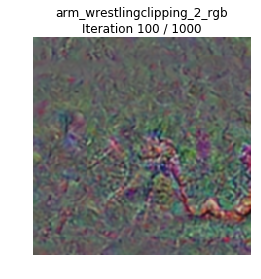

iteration: 100 33.2107868195
iteration: 101 33.4280569553
iteration: 102 33.7425098419
iteration: 103 33.9589679241
iteration: 104 34.1786539555
iteration: 105 34.5826339722
iteration: 106 34.8160438538
iteration: 107 35.0651268959
iteration: 108 35.4056239128
iteration: 109 35.6268978119
iteration: 110 35.8511087894
iteration: 111 36.1782138348
iteration: 112 36.4011609554
iteration: 113 36.6344058514
iteration: 114 36.9698708057
iteration: 115 37.2051827908
iteration: 116 37.4879968166
iteration: 117 37.8334579468
iteration: 118 38.0575559139
iteration: 119 38.2775518894
iteration: 120 38.6142048836
iteration: 121 38.8474609852
iteration: 122 39.1292369366
iteration: 123 39.4962279797
iteration: 124 39.7183899879


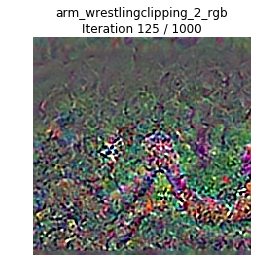

iteration: 125 40.0587618351
iteration: 126 40.3934059143
iteration: 127 40.6155018806
iteration: 128 40.8671059608
iteration: 129 41.2605948448
iteration: 130 41.4848709106
iteration: 131 41.7030949593
iteration: 132 42.010242939
iteration: 133 42.2169759274
iteration: 134 42.4237239361
iteration: 135 42.7254889011
iteration: 136 42.9365718365
iteration: 137 43.1524298191
iteration: 138 43.4982638359
iteration: 139 43.7225279808
iteration: 140 43.9785540104
iteration: 141 44.3676438332
iteration: 142 44.5964519978
iteration: 143 44.8446028233
iteration: 144 45.1889638901
iteration: 145 45.4167499542
iteration: 146 45.6882739067
iteration: 147 46.0754058361
iteration: 148 46.298842907
iteration: 149 46.5349609852


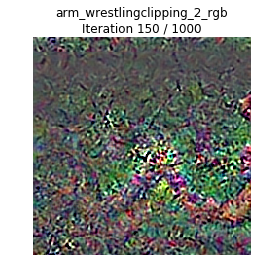

iteration: 150 47.08147192
iteration: 151 47.3107998371
iteration: 152 47.5583348274
iteration: 153 47.9655427933
iteration: 154 48.190600872
iteration: 155 48.4400010109
iteration: 156 48.882488966
iteration: 157 49.1260838509
iteration: 158 49.420593977
iteration: 159 49.8595290184
iteration: 160 50.1011269093
iteration: 161 50.374986887
iteration: 162 50.6960189342
iteration: 163 50.9173448086
iteration: 164 51.1535348892
iteration: 165 51.4813799858
iteration: 166 51.7062928677
iteration: 167 51.9608809948
iteration: 168 52.3885118961
iteration: 169 52.613478899
iteration: 170 52.8490028381
iteration: 171 53.2315998077
iteration: 172 53.4537699223
iteration: 173 53.6927688122
iteration: 174 54.1493499279


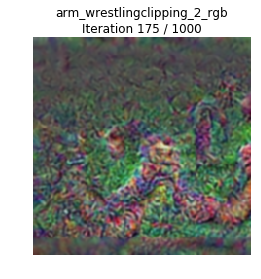

iteration: 175 54.484181881
iteration: 176 54.7255299091
iteration: 177 55.0681798458
iteration: 178 55.2901918888
iteration: 179 55.5241539478
iteration: 180 55.9568769932
iteration: 181 56.1893270016
iteration: 182 56.4417319298
iteration: 183 56.8656167984
iteration: 184 57.1074018478
iteration: 185 57.3922479153
iteration: 186 57.7955739498
iteration: 187 58.0262339115
iteration: 188 58.2754209042
iteration: 189 58.6768138409
iteration: 190 58.9154648781
iteration: 191 59.2036910057
iteration: 192 59.5721240044
iteration: 193 59.8069989681
iteration: 194 60.0961530209
iteration: 195 60.5442328453
iteration: 196 60.7794690132
iteration: 197 61.0316829681
iteration: 198 61.4005458355
iteration: 199 61.6317508221


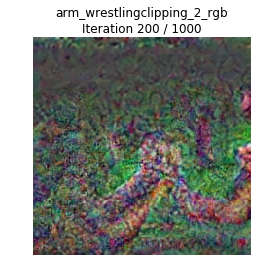

iteration: 200 62.016505003
iteration: 201 62.4586949348
iteration: 202 62.7116777897
iteration: 203 63.1351828575
iteration: 204 63.5270090103
iteration: 205 63.7701058388
iteration: 206 64.0596458912
iteration: 207 64.503371954
iteration: 208 64.7412469387
iteration: 209 65.0060999393
iteration: 210 65.4521768093
iteration: 211 65.699272871
iteration: 212 65.992223978
iteration: 213 66.4224460125
iteration: 214 66.6718478203
iteration: 215 66.9642817974
iteration: 216 67.4016888142
iteration: 217 67.6380388737
iteration: 218 67.9026918411
iteration: 219 68.356856823
iteration: 220 68.5991418362
iteration: 221 68.8608548641
iteration: 222 69.3097729683
iteration: 223 69.548584938
iteration: 224 69.8220248222


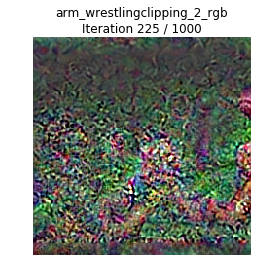

iteration: 225 70.3820059299
iteration: 226 70.6165139675
iteration: 227 70.8567218781
iteration: 228 71.3046989441
iteration: 229 71.5519478321
iteration: 230 71.8429038525
iteration: 231 72.2802908421
iteration: 232 72.5245518684
iteration: 233 72.7767999172
iteration: 234 73.1289420128
iteration: 235 73.3592488766
iteration: 236 73.6242778301
iteration: 237 74.0230698586
iteration: 238 74.2538290024
iteration: 239 74.5148599148
iteration: 240 74.9238629341
iteration: 241 75.1632008553
iteration: 242 75.4252929688
iteration: 243 75.8474287987
iteration: 244 76.0961518288
iteration: 245 76.3942329884
iteration: 246 76.8374459743
iteration: 247 77.0771977901
iteration: 248 77.3564147949
iteration: 249 77.7280828953


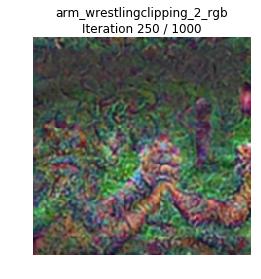

iteration: 250 78.0578079224
iteration: 251 78.3136518002
iteration: 252 78.7506568432
iteration: 253 78.9889140129
iteration: 254 79.2481617928
iteration: 255 79.6217319965
iteration: 256 79.8604888916
iteration: 257 80.1553268433
iteration: 258 80.5991308689
iteration: 259 80.8362078667
iteration: 260 81.0873990059
iteration: 261 81.4886608124
iteration: 262 81.7314867973
iteration: 263 81.9860258102
iteration: 264 82.4153988361
iteration: 265 82.6538889408
iteration: 266 82.9178528786
iteration: 267 83.3416810036
iteration: 268 83.5729689598
iteration: 269 83.8320958614
iteration: 270 84.2209079266
iteration: 271 84.4545259476
iteration: 272 84.7137768269
iteration: 273 85.150249958
iteration: 274 85.389966011


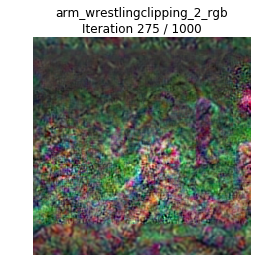

iteration: 275 85.7475578785
iteration: 276 86.1602578163
iteration: 277 86.3992109299
iteration: 278 86.6630148888
iteration: 279 87.1041018963
iteration: 280 87.3437919617
iteration: 281 87.6115689278
iteration: 282 88.0281260014
iteration: 283 88.2766358852
iteration: 284 88.5664539337
iteration: 285 88.9161548615
iteration: 286 89.1504299641
iteration: 287 89.4088258743
iteration: 288 89.8052268028
iteration: 289 90.0402929783
iteration: 290 90.295924902
iteration: 291 90.6191868782
iteration: 292 90.8525948524
iteration: 293 91.1047329903
iteration: 294 91.4270288944
iteration: 295 91.6578669548
iteration: 296 91.9038848877
iteration: 297 92.2580499649
iteration: 298 92.4902608395
iteration: 299 92.71814394


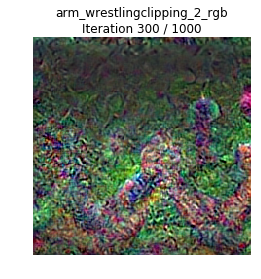

iteration: 300 93.1391220093
iteration: 301 93.3681969643
iteration: 302 93.6200778484
iteration: 303 93.9691898823
iteration: 304 94.1965138912
iteration: 305 94.4239988327
iteration: 306 94.7483818531
iteration: 307 94.9789907932
iteration: 308 95.2173829079
iteration: 309 95.5411868095
iteration: 310 95.7732059956
iteration: 311 96.0321819782
iteration: 312 96.4394099712
iteration: 313 96.6781888008
iteration: 314 96.9358568192
iteration: 315 97.2937958241
iteration: 316 97.5284259319
iteration: 317 97.7833650112
iteration: 318 98.1380898952
iteration: 319 98.3718488216
iteration: 320 98.6322188377
iteration: 321 99.0352239609
iteration: 322 99.2654359341
iteration: 323 99.4940969944
iteration: 324 99.8579318523


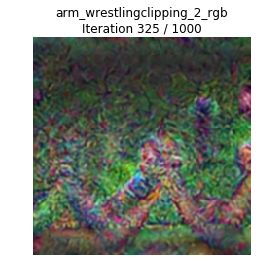

iteration: 325 100.188690901
iteration: 326 100.423669815
iteration: 327 100.814429998
iteration: 328 101.05221796
iteration: 329 101.305625916
iteration: 330 101.656583786
iteration: 331 101.895360947
iteration: 332 102.156085014
iteration: 333 102.564515829
iteration: 334 102.804026842
iteration: 335 103.064044952
iteration: 336 103.471704006
iteration: 337 103.71013999
iteration: 338 103.970054865
iteration: 339 104.364962816
iteration: 340 104.60213685
iteration: 341 104.86387682
iteration: 342 105.27451086
iteration: 343 105.513319016
iteration: 344 105.772897959
iteration: 345 106.127190828
iteration: 346 106.362788916
iteration: 347 106.618382931
iteration: 348 107.019973993
iteration: 349 107.257721901


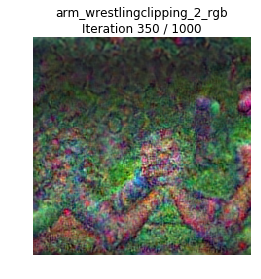

iteration: 350 107.621902943
iteration: 351 108.017362833
iteration: 352 108.252591848
iteration: 353 108.506841898
iteration: 354 108.865012884
iteration: 355 109.100909948
iteration: 356 109.361620903
iteration: 357 109.772385836
iteration: 358 110.010413885
iteration: 359 110.270078897
iteration: 360 110.678432941
iteration: 361 110.923888922
iteration: 362 111.183473825
iteration: 363 111.544317961
iteration: 364 111.781566858
iteration: 365 112.03686285
iteration: 366 112.408488989
iteration: 367 112.645859957
iteration: 368 112.906191826
iteration: 369 113.270303011
iteration: 370 113.519973993
iteration: 371 113.813570976
iteration: 372 114.26599288
iteration: 373 114.519949913
iteration: 374 114.788224936


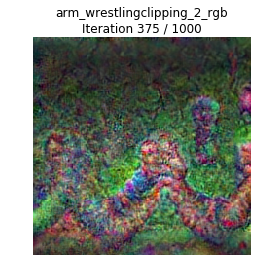

iteration: 375 115.243414879
iteration: 376 115.467633009
iteration: 377 115.723224878
iteration: 378 116.126900911
iteration: 379 116.366098881
iteration: 380 116.628988981
iteration: 381 117.030970812
iteration: 382 117.266971827
iteration: 383 117.505637884
iteration: 384 117.884440899
iteration: 385 118.122360945
iteration: 386 118.38535285
iteration: 387 118.79626894
iteration: 388 119.046258926
iteration: 389 119.337970018
iteration: 390 119.790252924
iteration: 391 120.043820858
iteration: 392 120.342667818
iteration: 393 120.780375004
iteration: 394 121.030885935
iteration: 395 121.330868959
iteration: 396 121.768785954
iteration: 397 122.017469883
iteration: 398 122.272840023
iteration: 399 122.666656017


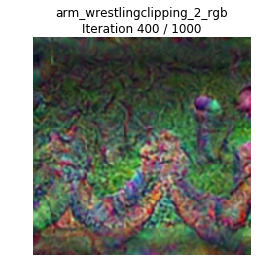

iteration: 400 123.015882969
iteration: 401 123.277084827
iteration: 402 123.680160999
iteration: 403 123.92157197
iteration: 404 124.187706947
iteration: 405 124.593971014
iteration: 406 124.833604813
iteration: 407 125.092218876
iteration: 408 125.449512959
iteration: 409 125.688391924
iteration: 410 125.953425884
iteration: 411 126.362494946
iteration: 412 126.598815918
iteration: 413 126.839329004
iteration: 414 127.23477602
iteration: 415 127.468808889
iteration: 416 127.739343882
iteration: 417 128.116441011
iteration: 418 128.354558945
iteration: 419 128.631677866
iteration: 420 129.08868289
iteration: 421 129.329186916
iteration: 422 129.578686953
iteration: 423 129.970758915
iteration: 424 130.212688923


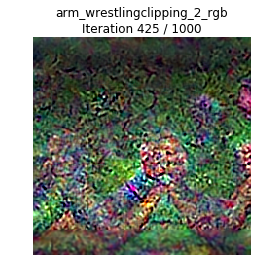

iteration: 425 130.582798004
iteration: 426 131.037564993
iteration: 427 131.278265953
iteration: 428 131.51739502
iteration: 429 131.907554865
iteration: 430 132.148676872
iteration: 431 132.413239956
iteration: 432 132.82373786
iteration: 433 133.067734957
iteration: 434 133.326336861
iteration: 435 133.656117916
iteration: 436 133.894850016
iteration: 437 134.156930923
iteration: 438 134.529700994
iteration: 439 134.770711899
iteration: 440 135.042455912
iteration: 441 135.436503887
iteration: 442 135.674234867
iteration: 443 135.931286812
iteration: 444 136.29406786
iteration: 445 136.535297871
iteration: 446 136.802721024
iteration: 447 137.212854862
iteration: 448 137.451854944
iteration: 449 137.691603899


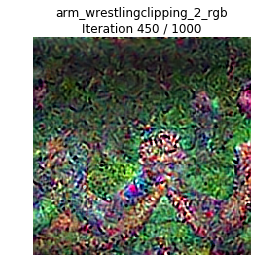

iteration: 450 138.188753843
iteration: 451 138.43194294
iteration: 452 138.665848017
iteration: 453 138.995277882
iteration: 454 139.235088825
iteration: 455 139.483318806
iteration: 456 139.865007877
iteration: 457 140.10707593
iteration: 458 140.359879017
iteration: 459 140.762801886
iteration: 460 141.007086992
iteration: 461 141.25061202
iteration: 462 141.593367815
iteration: 463 141.851135969
iteration: 464 142.119503975
iteration: 465 142.482530832
iteration: 466 142.724913836
iteration: 467 142.992118835
iteration: 468 143.408957958
iteration: 469 143.662699938
iteration: 470 143.963240862
iteration: 471 144.404755831
iteration: 472 144.653664827
iteration: 473 144.917104006
iteration: 474 145.366044998


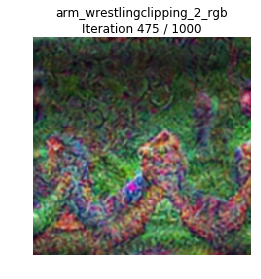

iteration: 475 145.713111877
iteration: 476 145.946080923
iteration: 477 146.285314798
iteration: 478 146.529177904
iteration: 479 146.795149803
iteration: 480 147.204907894
iteration: 481 147.451978922
iteration: 482 147.729012966
iteration: 483 148.181075811
iteration: 484 148.430081844
iteration: 485 148.684068918
iteration: 486 149.088233948
iteration: 487 149.332057953
iteration: 488 149.593691826
iteration: 489 149.977954865
iteration: 490 150.23080492
iteration: 491 150.539239883
iteration: 492 150.969014883
iteration: 493 151.226737976
iteration: 494 151.527858019
iteration: 495 151.964994907
iteration: 496 152.255833864
iteration: 497 152.565003872
iteration: 498 152.987183809
iteration: 499 153.244926929


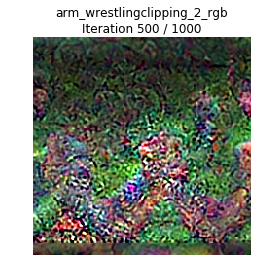

iteration: 500 153.68453002
iteration: 501 154.107713938
iteration: 502 154.353954792
iteration: 503 154.621857882
iteration: 504 155.060065985
iteration: 505 155.309132814
iteration: 506 155.558540821
iteration: 507 155.960155964
iteration: 508 156.213143826
iteration: 509 156.49357295
iteration: 510 156.908335924
iteration: 511 157.165069818
iteration: 512 157.482280016
iteration: 513 157.938768864
iteration: 514 158.197185993
iteration: 515 158.5011518
iteration: 516 158.956151009
iteration: 517 159.20783782
iteration: 518 159.485857964
iteration: 519 159.945801973
iteration: 520 160.197078943
iteration: 521 160.477778912
iteration: 522 160.879001856
iteration: 523 161.134413958
iteration: 524 161.457988977


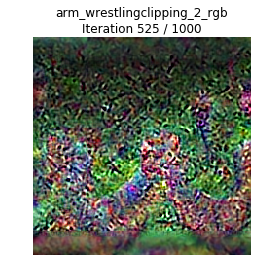

iteration: 525 162.070726871
iteration: 526 162.325052977
iteration: 527 162.609097958
iteration: 528 163.081224918
iteration: 529 163.338842869
iteration: 530 163.640420914
iteration: 531 164.103883982
iteration: 532 164.359227896
iteration: 533 164.618932009
iteration: 534 165.018764973
iteration: 535 165.265184879
iteration: 536 165.544726849
iteration: 537 165.996678829
iteration: 538 166.256189823
iteration: 539 166.563486814
iteration: 540 167.014339924
iteration: 541 167.268417835
iteration: 542 167.55131197
iteration: 543 168.007915974
iteration: 544 168.258243799
iteration: 545 168.528407812
iteration: 546 168.940963984
iteration: 547 169.188442945
iteration: 548 169.468799829
iteration: 549 169.907402992


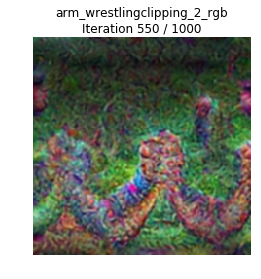

iteration: 550 170.266366959
iteration: 551 170.542383909
iteration: 552 170.951545954
iteration: 553 171.203725815
iteration: 554 171.481442928
iteration: 555 171.885325909
iteration: 556 172.142577887
iteration: 557 172.448759794
iteration: 558 172.904742956
iteration: 559 173.16633296
iteration: 560 173.462915897
iteration: 561 173.912895918
iteration: 562 174.177124977
iteration: 563 174.479514837
iteration: 564 174.928792953
iteration: 565 175.190212965
iteration: 566 175.502820015
iteration: 567 175.944197893
iteration: 568 176.197685003
iteration: 569 176.471662998
iteration: 570 176.884980917
iteration: 571 177.141596794
iteration: 572 177.456444979
iteration: 573 177.93866086
iteration: 574 178.206769943


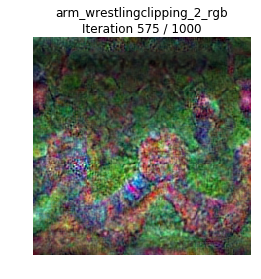

iteration: 575 178.617686987
iteration: 576 179.018965006
iteration: 577 179.280108929
iteration: 578 179.594867945
iteration: 579 180.026453972
iteration: 580 180.288607836
iteration: 581 180.578244925
iteration: 582 181.0429039
iteration: 583 181.308410883
iteration: 584 181.614719868
iteration: 585 182.041749954
iteration: 586 182.29694581
iteration: 587 182.57733798
iteration: 588 183.050415993
iteration: 589 183.303541899
iteration: 590 183.571323872
iteration: 591 183.977628946
iteration: 592 184.2295928
iteration: 593 184.521808863
iteration: 594 184.946209908
iteration: 595 185.194485903
iteration: 596 185.43986392
iteration: 597 185.815775871
iteration: 598 186.066756964
iteration: 599 186.339483023


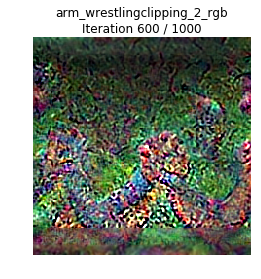

iteration: 600 186.845049858
iteration: 601 187.094188929
iteration: 602 187.368150949
iteration: 603 187.73506999
iteration: 604 187.982221842
iteration: 605 188.256783009
iteration: 606 188.667020798
iteration: 607 188.91870594
iteration: 608 189.165748835
iteration: 609 189.567322969
iteration: 610 189.818051815
iteration: 611 190.087971926
iteration: 612 190.439081907
iteration: 613 190.6848979
iteration: 614 190.94965291
iteration: 615 191.277613878
iteration: 616 191.50919795
iteration: 617 191.747056007
iteration: 618 192.098423004
iteration: 619 192.331921816
iteration: 620 192.596715927
iteration: 621 192.988305807
iteration: 622 193.245044947
iteration: 623 193.520844936
iteration: 624 193.931226015


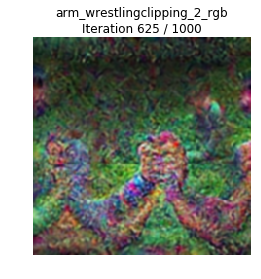

iteration: 625 194.284240007
iteration: 626 194.558501005
iteration: 627 194.956326962
iteration: 628 195.205976009
iteration: 629 195.486989021
iteration: 630 195.853307962
iteration: 631 196.10144186
iteration: 632 196.375947952
iteration: 633 196.787431955
iteration: 634 197.048499823
iteration: 635 197.360835791
iteration: 636 197.751645803
iteration: 637 197.998970985
iteration: 638 198.270148993
iteration: 639 198.675546885
iteration: 640 198.928027868
iteration: 641 199.203230858
iteration: 642 199.613819838
iteration: 643 199.865796804
iteration: 644 200.11814189
iteration: 645 200.493812799
iteration: 646 200.745605946
iteration: 647 201.029227018
iteration: 648 201.481239796
iteration: 649 201.74800086


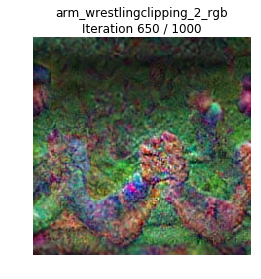

iteration: 650 202.117404938
iteration: 651 202.50292182
iteration: 652 202.797044992
iteration: 653 203.074627876
iteration: 654 203.488418818
iteration: 655 203.743817806
iteration: 656 204.029981852
iteration: 657 204.471783876
iteration: 658 204.726676941
iteration: 659 204.999979019
iteration: 660 205.381712914
iteration: 661 205.632748842
iteration: 662 205.882893801
iteration: 663 206.287106991
iteration: 664 206.539407015
iteration: 665 206.821966887
iteration: 666 207.240254879
iteration: 667 207.493876934
iteration: 668 207.770916939
iteration: 669 208.180722952
iteration: 670 208.434089899
iteration: 671 208.710000992
iteration: 672 209.090329885
iteration: 673 209.344188929
iteration: 674 209.628654957


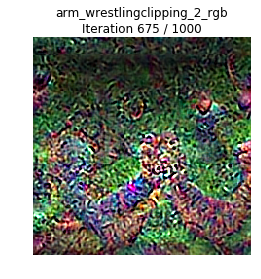

iteration: 675 210.168596983
iteration: 676 210.421819925
iteration: 677 210.6991539
iteration: 678 211.099223852
iteration: 679 211.347929001
iteration: 680 211.598692894
iteration: 681 211.955128908
iteration: 682 212.202023983
iteration: 683 212.454262972
iteration: 684 212.847819805
iteration: 685 213.095096827
iteration: 686 213.346362829
iteration: 687 213.707177877
iteration: 688 213.956648827
iteration: 689 214.217233896
iteration: 690 214.600054979
iteration: 691 214.84956193
iteration: 692 215.102427959
iteration: 693 215.515177965
iteration: 694 215.7736938
iteration: 695 216.048200846
iteration: 696 216.455529928
iteration: 697 216.710970879
iteration: 698 216.988344908
iteration: 699 217.35153389


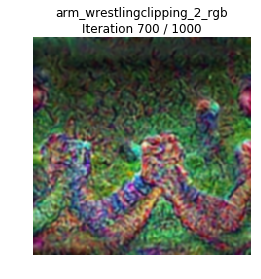

iteration: 700 217.712319851
iteration: 701 217.998348951
iteration: 702 218.413058996
iteration: 703 218.668829918
iteration: 704 218.943338871
iteration: 705 219.312216997
iteration: 706 219.565137863
iteration: 707 219.845921993
iteration: 708 220.264083862
iteration: 709 220.514717817
iteration: 710 220.76888895
iteration: 711 221.176432848
iteration: 712 221.430413961
iteration: 713 221.707259893
iteration: 714 222.069885015
iteration: 715 222.327725887
iteration: 716 222.616385937
iteration: 717 223.077813864
iteration: 718 223.329222918
iteration: 719 223.579437017
iteration: 720 223.965147018
iteration: 721 224.222970963
iteration: 722 224.505065918
iteration: 723 224.919220924
iteration: 724 225.170417786


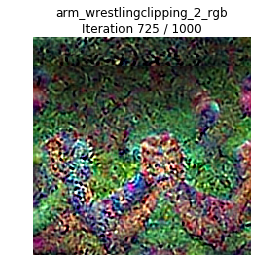

iteration: 725 225.511901855
iteration: 726 225.866093874
iteration: 727 226.123457909
iteration: 728 226.390725851
iteration: 729 226.770089865
iteration: 730 227.029175997
iteration: 731 227.278059006
iteration: 732 227.630189896
iteration: 733 227.874428988
iteration: 734 228.113996983
iteration: 735 228.476986885
iteration: 736 228.722108841
iteration: 737 229.000129938
iteration: 738 229.413753986
iteration: 739 229.670503855
iteration: 740 229.950706005
iteration: 741 230.364859819
iteration: 742 230.629635811
iteration: 743 230.949999809
iteration: 744 231.392619848
iteration: 745 231.653908014
iteration: 746 231.928332806
iteration: 747 232.30771184
iteration: 748 232.564827919
iteration: 749 232.841280937


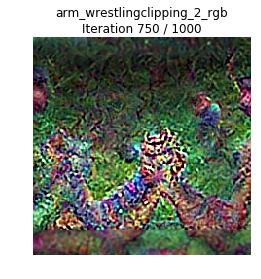

iteration: 750 233.347426891
iteration: 751 233.621199846
iteration: 752 233.9420259
iteration: 753 234.538957834
iteration: 754 234.799962997
iteration: 755 235.079501867
iteration: 756 235.490674019
iteration: 757 235.755286932
iteration: 758 236.017507792
iteration: 759 236.395520926
iteration: 760 236.657164812
iteration: 761 236.940335989
iteration: 762 237.317699909
iteration: 763 237.57322979
iteration: 764 237.835640907
iteration: 765 238.251236916
iteration: 766 238.515990019
iteration: 767 238.802438021
iteration: 768 239.182384968
iteration: 769 239.446321011
iteration: 770 239.733362913
iteration: 771 240.144500017
iteration: 772 240.414354801
iteration: 773 240.701035976
iteration: 774 241.116178989


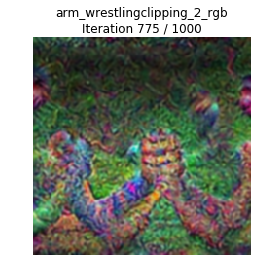

iteration: 775 241.489059925
iteration: 776 241.787464857
iteration: 777 242.199790955
iteration: 778 242.468385935
iteration: 779 242.756400824
iteration: 780 243.208702803
iteration: 781 243.481200933
iteration: 782 243.769606829
iteration: 783 244.1811378
iteration: 784 244.445824862
iteration: 785 244.738969803
iteration: 786 245.188905954
iteration: 787 245.469077826
iteration: 788 245.754830837
iteration: 789 246.143548012
iteration: 790 246.408689976
iteration: 791 246.69825983
iteration: 792 247.110309839
iteration: 793 247.374109983
iteration: 794 247.660964012
iteration: 795 248.075821877
iteration: 796 248.340518951
iteration: 797 248.636789799
iteration: 798 249.099032879
iteration: 799 249.370330811


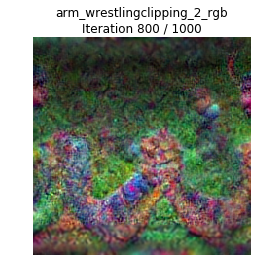

iteration: 800 249.757927895
iteration: 801 250.173096895
iteration: 802 250.438049793
iteration: 803 250.726341009
iteration: 804 251.10450387
iteration: 805 251.367179871
iteration: 806 251.629360914
iteration: 807 252.009332895
iteration: 808 252.273526907
iteration: 809 252.562157869
iteration: 810 252.975967884
iteration: 811 253.2420609
iteration: 812 253.533416986
iteration: 813 253.952786922
iteration: 814 254.219985962
iteration: 815 254.513932943
iteration: 816 254.927246809
iteration: 817 255.194645882
iteration: 818 255.481884956
iteration: 819 255.858633995
iteration: 820 256.125329971
iteration: 821 256.411307812
iteration: 822 256.825380802
iteration: 823 257.092171907
iteration: 824 257.382608891


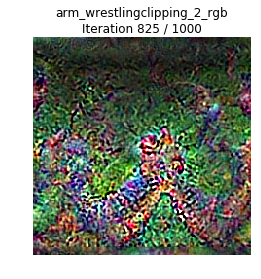

iteration: 825 257.862129927
iteration: 826 258.131963015
iteration: 827 258.423463821
iteration: 828 258.836583853
iteration: 829 259.104295015
iteration: 830 259.391009808
iteration: 831 259.74550581
iteration: 832 260.003882885
iteration: 833 260.263960838
iteration: 834 260.654303789
iteration: 835 260.921059847
iteration: 836 261.209342003
iteration: 837 261.615047932
iteration: 838 261.883196831
iteration: 839 262.167737961
iteration: 840 262.526029825
iteration: 841 262.793558836
iteration: 842 263.079862833
iteration: 843 263.465376854
iteration: 844 263.733436823
iteration: 845 264.023952007
iteration: 846 264.441349983
iteration: 847 264.709836006
iteration: 848 265.004287004
iteration: 849 265.393417835


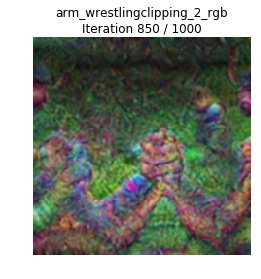

iteration: 850 265.764968872
iteration: 851 266.031157017
iteration: 852 266.427815914
iteration: 853 266.691569805
iteration: 854 266.969717979
iteration: 855 267.364460945
iteration: 856 267.631206989
iteration: 857 267.918155909
iteration: 858 268.33672595
iteration: 859 268.603964806
iteration: 860 268.885582924
iteration: 861 269.265152931
iteration: 862 269.533449888
iteration: 863 269.822625875
iteration: 864 270.241823912
iteration: 865 270.510366917
iteration: 866 270.802563906
iteration: 867 271.217676878
iteration: 868 271.487592936
iteration: 869 271.782631874
iteration: 870 272.16373682
iteration: 871 272.430720806
iteration: 872 272.721313953
iteration: 873 273.100576878
iteration: 874 273.366595984


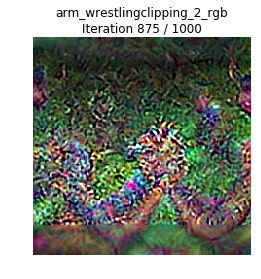

iteration: 875 273.75700593
iteration: 876 274.149856806
iteration: 877 274.417307854
iteration: 878 274.7084589
iteration: 879 275.098435879
iteration: 880 275.363076925
iteration: 881 275.652912855
iteration: 882 276.065269947
iteration: 883 276.34222579
iteration: 884 276.670441866
iteration: 885 277.109109879
iteration: 886 277.378623962
iteration: 887 277.668895006
iteration: 888 278.087018967
iteration: 889 278.359422922
iteration: 890 278.645202875
iteration: 891 279.00106287
iteration: 892 279.268865824
iteration: 893 279.568029881
iteration: 894 280.033268929
iteration: 895 280.302164793
iteration: 896 280.574987888
iteration: 897 281.013208866
iteration: 898 281.291080952
iteration: 899 281.584182978


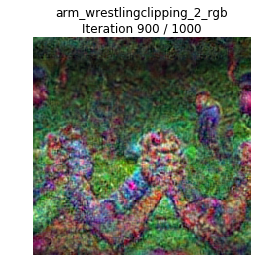

iteration: 900 282.105041981
iteration: 901 282.386820793
iteration: 902 282.696731806
iteration: 903 283.151976824
iteration: 904 283.426625967
iteration: 905 283.742168903
iteration: 906 284.245188951
iteration: 907 284.542670965
iteration: 908 284.87084794
iteration: 909 285.300796986
iteration: 910 285.572940826
iteration: 911 285.870279789
iteration: 912 286.313427925
iteration: 913 286.580529928
iteration: 914 286.852618933
iteration: 915 287.238396883
iteration: 916 287.504270792
iteration: 917 287.772362947
iteration: 918 288.138840914
iteration: 919 288.393414974
iteration: 920 288.658819914
iteration: 921 289.117175817
iteration: 922 289.390543938
iteration: 923 289.68350482
iteration: 924 290.101713896


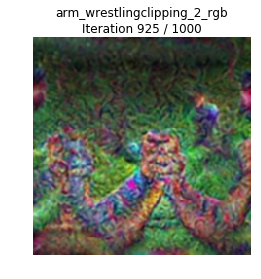

iteration: 925 290.475309849
iteration: 926 290.76483202
iteration: 927 291.147228956
iteration: 928 291.411715984
iteration: 929 291.700357914
iteration: 930 292.183614969
iteration: 931 292.466506958
iteration: 932 292.792117834
iteration: 933 293.194936991
iteration: 934 293.467613935
iteration: 935 293.76582098
iteration: 936 294.23793602
iteration: 937 294.529912949
iteration: 938 294.836083889
iteration: 939 295.256588936
iteration: 940 295.531280994
iteration: 941 295.838598013
iteration: 942 296.269779921
iteration: 943 296.544797897
iteration: 944 296.840890884
iteration: 945 297.222169876
iteration: 946 297.505208969
iteration: 947 297.852372885
iteration: 948 298.336083889
iteration: 949 298.624591827


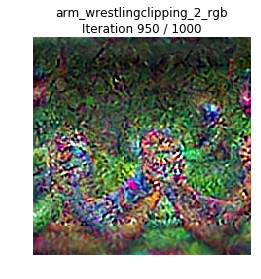

iteration: 950 299.072336912
iteration: 951 299.4886868
iteration: 952 299.772261858
iteration: 953 300.10550499
iteration: 954 300.538401842
iteration: 955 300.812722921
iteration: 956 301.116832972
iteration: 957 301.586108923
iteration: 958 301.866245985
iteration: 959 302.178748846
iteration: 960 302.565017939
iteration: 961 302.834587812
iteration: 962 303.1037848
iteration: 963 303.514583826
iteration: 964 303.788079977
iteration: 965 304.074216843
iteration: 966 304.482102871
iteration: 967 304.754321814
iteration: 968 305.062223911
iteration: 969 305.532344818
iteration: 970 305.811901808
iteration: 971 306.110613823
iteration: 972 306.533190012
iteration: 973 306.807478905
iteration: 974 307.107543945


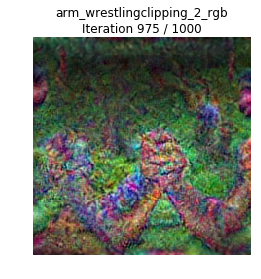

iteration: 975 307.636409998
iteration: 976 307.909559965
iteration: 977 308.206143856
iteration: 978 308.62992692
iteration: 979 308.902709007
iteration: 980 309.207498789
iteration: 981 309.703326941
iteration: 982 309.984634876
iteration: 983 310.294503927
iteration: 984 310.770581007
iteration: 985 311.060815811
iteration: 986 311.396627903
iteration: 987 311.831751823
iteration: 988 312.10541296
iteration: 989 312.404976845
iteration: 990 312.826244831
iteration: 991 313.100605011
iteration: 992 313.398249865
iteration: 993 313.818781853
iteration: 994 314.108388901
iteration: 995 314.441408873
iteration: 996 314.881368876
iteration: 997 315.156728983
iteration: 998 315.456833839
iteration: 999 315.892315865
file_name experiments_rgb/arm_wrestlingclipping_2/arm_wrestlingclipping_2_rgb{}.png


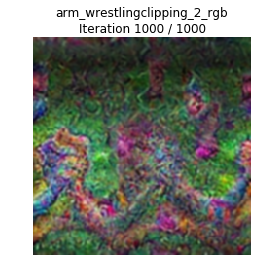

In [6]:
"""
Run RGB visualization only
"""
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(model_logits)
print(rgb_input)
target = 6
print(kinetics_classes[target])
action_name = kinetics_classes[target].replace(" ", "_")
with tf.device("/gpu:0"):
    with tf.Session() as sess:
        # THIS LINE NEEDS TO BE MOVED
        rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
        # number of frames must be >= 9 or else kernel crashes
        rgb_visual_gif = create_class_visualization(sess, rgb_input, flow_input, target, rgb_logits, action_name + "clipping_2", 
                                   stream_type='rgb', num_frames=25, num_iterations=1000, learning_rate=1.5, 
                                   blur_every=3, max_jitter=32)

In [ ]:
"""
Run FLOW visualization only
"""
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
print(model_logits)
print(flow_input)
target = 171
print(kinetics_classes[target])
action_name = kinetics_classes[target].replace(" ", "_")
with tf.device("/gpu:0"):
    with tf.Session() as sess:
        # THIS LINE NEEDS TO BE MOVED
        flow_saver.restore(sess, _CHECKPOINT_PATHS['flow_imagenet'])
        flow_visual_gif = create_class_visualization(sess, rgb_input, flow_input, target, flow_logits, action_name + "test", stream_type='flow', num_frames=25, num_iterations=1000, l2_reg=1e-2, learning_rate=1.5, blur_every=10, max_jitter=32, sigma=.5)

In [ ]:
"""
Print all classes
"""
indexes = range(len(kinetics_classes))
class_to_index = dict(zip(kinetics_classes, indexes))
index_to_class = dict(zip(indexes, kinetics_classes))
#print(index_to_class)

temp = np.append(0*np.ones((224, 224, 1)), -.205*np.ones((224, 224, 1)), axis=2)
plt.imshow(create_flow_image(temp))